In [70]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List


def euclid_distance(p1, p2):
    return np.sqrt(
        sum([(p2[i] - p1[i])**2 for i in range(3)])
    )

BETA = 2/3e9

class Element:
    def __init__(self, x, y, z, width, height, length):
        self.x0 = x
        self.y0 = y
        self.z0 = z
        self.x1 = x + width
        self.y1 = y + height
        self.z1 = z + length

        self.l = length
        self.w = width
        self.h = height
        
        # maybe calculate but don't know which side 
        self.area = 0.0
        self.AA = self.l * self.w
        self.AB = self.l * self.h
        self.AC = self.w * self.h
    
        self.I = 0.0
        self._centre = ((self.w - self.x0) / 2, (self.w - self.y0) / 2,
                        (self.l - self.z0) / 2)

    def get_contribution_at_p(self, p) -> float:
        if self.I == 0.0:
            raise ValueError("Current not set")
        dist = euclid_distance(p, self._centre)
        return BETA*self.I/dist

    def set_current(self, I):
        self.I = I
        
    def set_current_density(self, Iden):
        if self.area == 0.0:
            raise ValueErrorl("Area not set")
        self.I = Iden * (self.area)
        
    def get_sides(self):
        return [
            # FRONT FACE
            [(self.x0, self.y0, self.z0), (self.x1, self.y0, self.z0),
             (self.x1, self.y1, self.z0), (self.x0, self.y1, self.z0)],

            # BACK FACE
            [(self.x0, self.y0, self.z1), (self.x1, self.y0, self.z1),
             (self.x1, self.y1, self.z1), (self.x0, self.y1, self.z1)],

            # LEFT FACE
            [(self.x0, self.y0, self.z0), (self.x0, self.y0, self.z1),
             (self.x0, self.y1, self.z1), (self.x0, self.y1, self.z0)],

            # RIGHT FACE
            [(self.x1, self.y0, self.z0), (self.x1, self.y0, self.z1),
             (self.x1, self.y1, self.z1), (self.x1, self.y1, self.z0)],

            # TOP FACE
            [(self.x0, self.y1, self.z0), (self.x1, self.y1, self.z0),
             (self.x1, self.y1, self.z1), (self.x0, self.y1, self.z1)],

            # BOTTOM FACE
            [(self.x0, self.y0, self.z0), (self.x1, self.y0, self.z0),
             (self.x1, self.y0, self.z1), (self.x0, self.y0, self.z1)],
        ]


def mesh_discretisation(swidth, sheight, slength, rwidth, rheight,
                        rlength) -> List[Element]:
    Nz, Nx, Ny = int(slength / rlength), int(swidth / rwidth), int(sheight /
                                                                   rheight)
    element_groups: List[Element] = []
    for ix in range(Nx):
        for iy in range(Ny):
            for iz in range(Nz):
                el = Element(ix * rwidth, iy * rheight, iz * rlength, rwidth,
                             rheight, rlength)
                element_groups.append(el)

    return element_groups

In [71]:
def calculate_circular_slice(elements: List[Element],
                             slice_disk_centre: tuple,
                             disk_radius: float,
                             ad: float = 360,
                             rd: float = 1):
    angle_step = 2 * np.pi / ad
    N_rad = disk_radius / rd

    points = []
    start = slice_disk_centre
    # x = r*cos(ang)
    # y = r*sin(ang)
    for ai in range(ad):
        for radius_step in range(N_rad):
            x = radius_step * rd * np.cos(angle_step * ai) + slice_disk_centre[0]
            y = radius_step * rd * np.sin(angle_step * ai) + slice_disk_centre[1]
            z = slice_disk_centre[2]

            points.append((x, y))
            points_contributions = 0.0
            el: Element
            for el in elements:
                points_contributions += el.get_contribution_at_p((x, y, z))
            vals.append(points_contributions)
    return points

In [67]:
# x, y, z 

sizeW = 30 
sizeL = 50
sizeH = 5

max_grid = max(sizeW, sizeL, sizeH)
elements = mesh_discretisation(30, 50, 10, 10, 10, 1)

disk_centre = (15, 25, 5)
zp = disk_centre[2]
x = y = np.arange(-disk_centre[1]*2, disk_centre[1]*2, 2)
print(max(y))
X, Y = np.meshgrid(x, y)
org_s = X.shape
Z = []
current = 1e-3
for el in elements:
    el.set_current(current)
for xp, yp in zip(X.ravel(), Y.ravel()):
    p = (xp, yp, zp)
    el: Element
    points_contributions = 0.0
    for el in elements:
        points_contributions += el.get_contribution_at_p((xp, yp, zp))
    Z.append(points_contributions)

Z = np.array(Z).reshape(org_s)

48


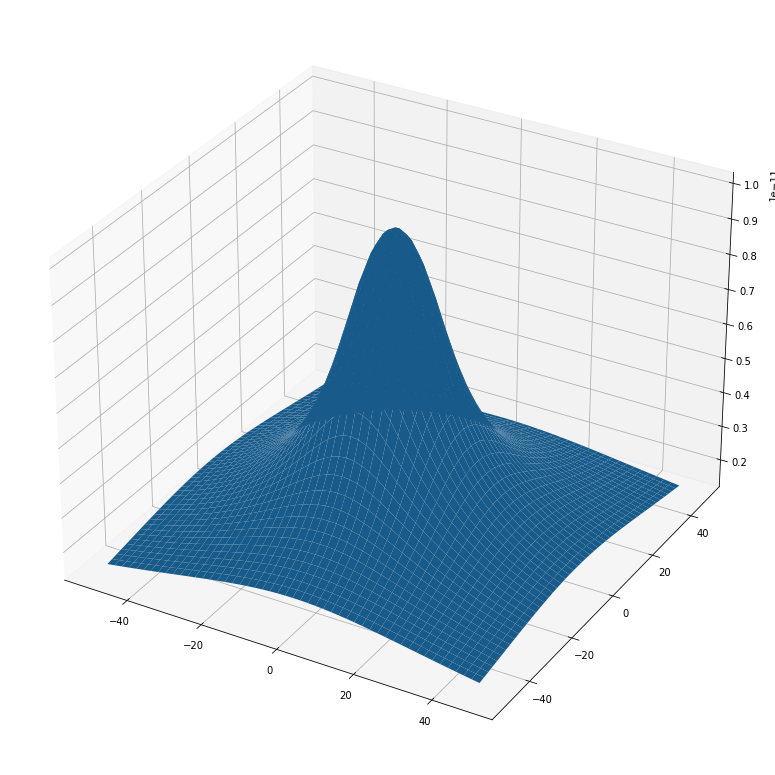

In [68]:
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)

<IPython.core.display.Javascript object>


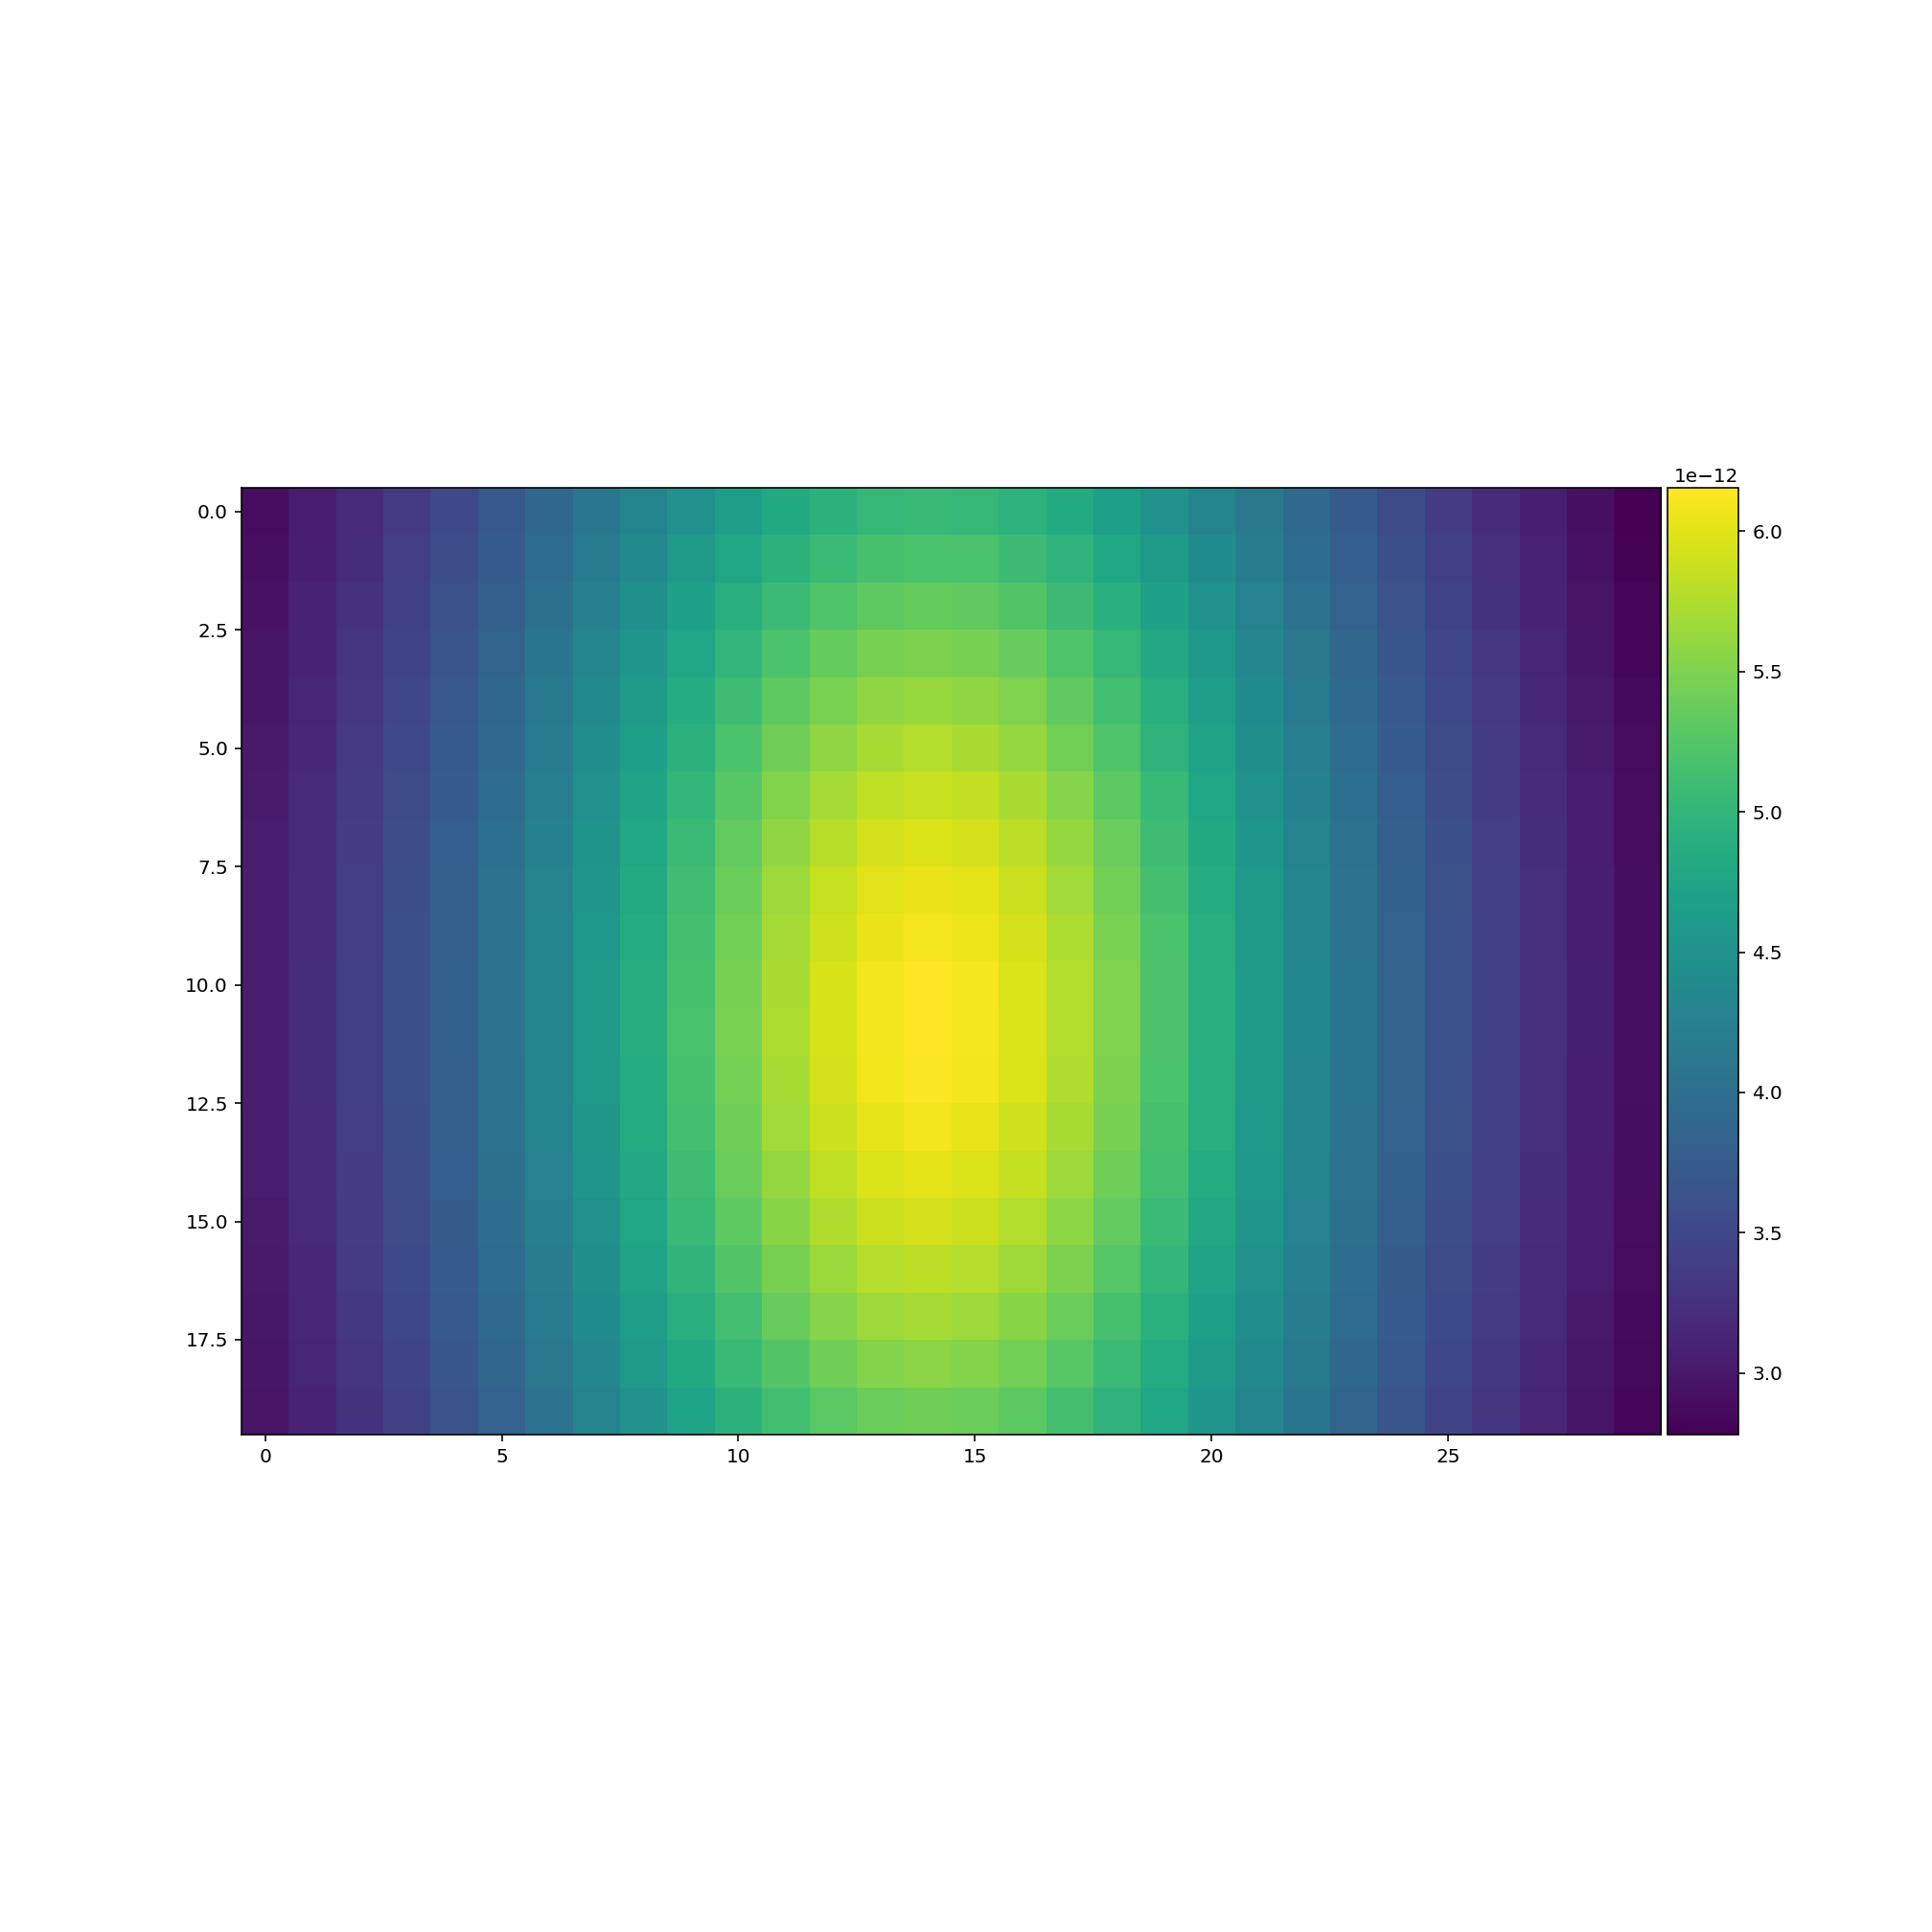

In [83]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

sizeW = 30 
sizeL = 50
sizeH = 5


elements = mesh_discretisation(sizeW, sizeH, sizeL, 5, 1, 5)
current = 1e-3
for el in elements:
    el.set_current(current)

z_slice = sizeL/2

y = np.arange(-sizeH*4, sizeH*4, 2)
x = np.arange(-sizeW*2, sizeW*2, 4)
X, Y = np.meshgrid(x, y)
org_s = X.shape
vals = calculate_contribs(X.ravel(), Y.ravel(), z_slice).reshape(org_s)


fig, ax = plt.subplots(figsize=(14, 14))

im = ax.imshow(vals)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

cb = fig.colorbar(im, cax=cax, orientation='vertical')



In [81]:
print(len(elements))

300


<IPython.core.display.Javascript object>


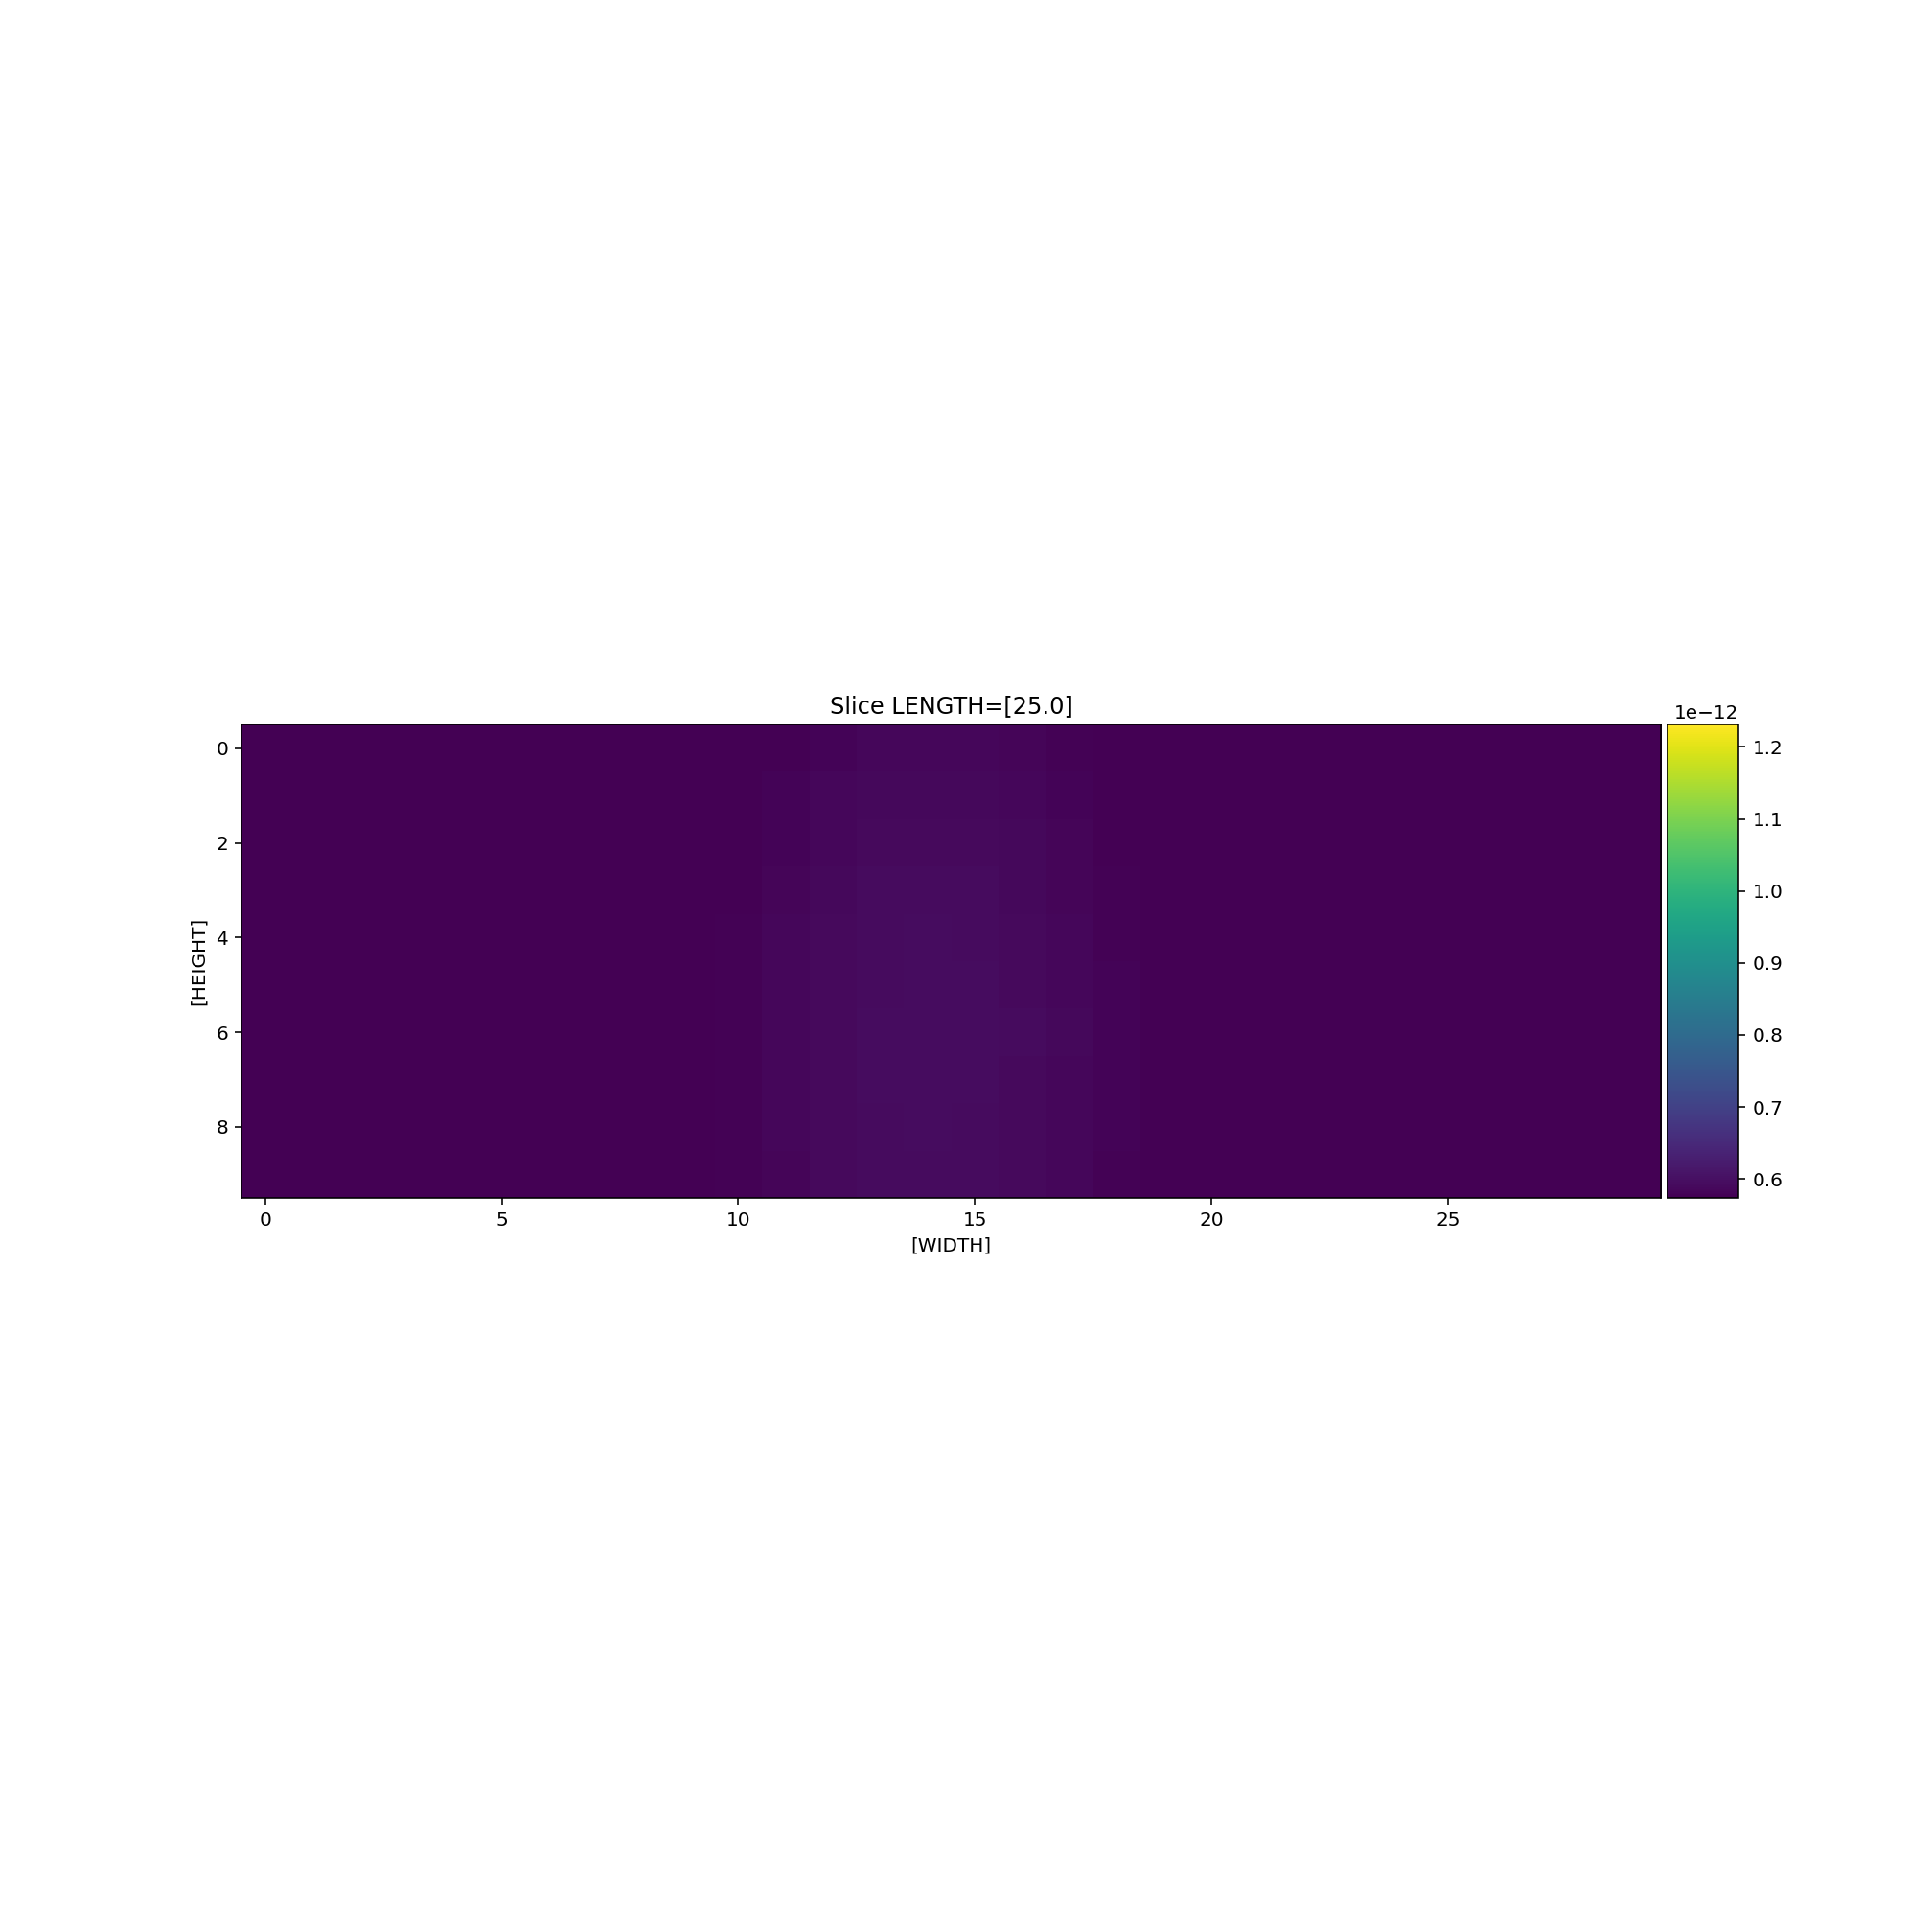

interactive(children=(FloatSlider(value=25.0, description='zs', max=75.0, min=-25.0), Output()), _dom_classes=…

<function __main__.update(zs=25.0)>

In [88]:
%matplotlib notebook
from mpl_toolkits.axes_grid1 import make_axes_locatable
import ipywidgets as ipw

def calculate_contribs(Xs, Ys, z_slice):
    vals = []
    for xp, yp in zip(Xs, Ys):
        p = (xp, yp, z_slice)
        el: Element
        points_contributions = 0.0
        for el in elements:
            points_contributions += el.get_contribution_at_p(p)
        vals.append(points_contributions)
    return np.array(vals)


sizeW = 30 
sizeL = 50
sizeH = 5


elements = mesh_discretisation(sizeW, sizeH, sizeL, 5, 5, 5)

z_slice = sizeL/2

y = np.arange(-sizeH*2, sizeH*2, 2)
x = np.arange(-sizeW*2, sizeW*2, 4)
X, Y = np.meshgrid(x, y)
org_s = X.shape

current = 1e-3
for el in elements:
    el.set_current(current)


vals = calculate_contribs(X.ravel(), Y.ravel(), z_slice).reshape(org_s)
    
fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xlabel("[WIDTH]")
ax.set_ylabel("[HEIGHT]")
im = ax.imshow(vals)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

cb = fig.colorbar(im, cax=cax, orientation='vertical')


def update(zs=z_slice):
    vals_tmp = calculate_contribs(X.ravel(), Y.ravel(), zs).reshape(org_s)
    im.set_data(vals_tmp)
    ax.set_title(f"Slice LENGTH=[{z_slice}]")

ipw.interact(update, freq = ipw.FloatSlider(value=z_slice,
                                               min=-sizeL/2,
                                               max=sizeL+ sizeL/2,
                                               step=0.5))

# Elements: 300


Text(0.5, 0, 'Z [LENGTH]')

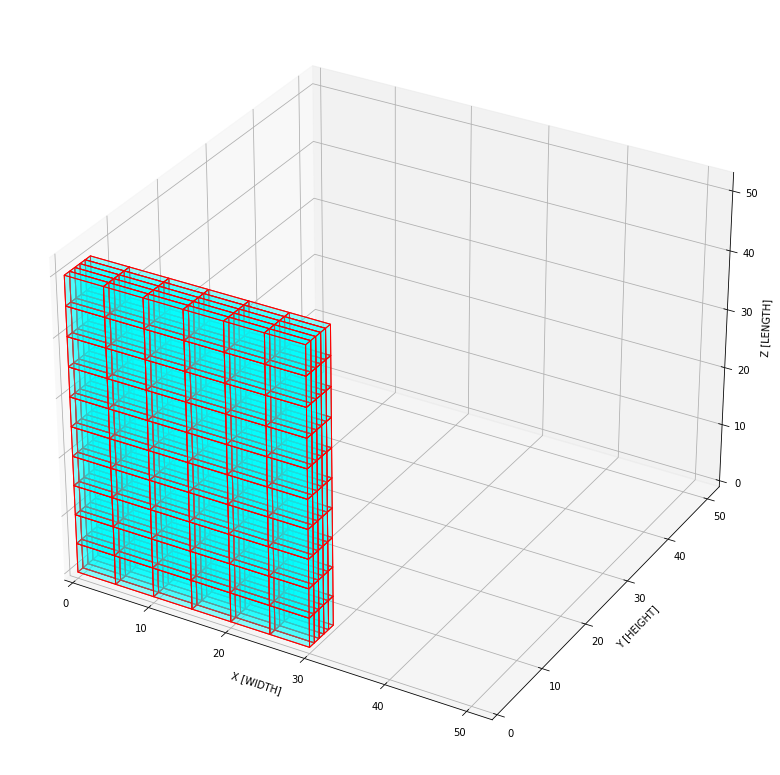

In [85]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection


sizeW = 30 
sizeL = 50
sizeH = 5

max_grid = max(sizeW, sizeL, sizeH)
elements = mesh_discretisation(sizeW, sizeH, sizeL, 5, 1, 5)

fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')
print(f"# Elements: {len(elements)}")

for el in elements:
    sides = el.get_sides()
    ax.add_collection3d(Poly3DCollection(sides, 
     facecolors='cyan', linewidths=1, edgecolors='r', alpha=.25))
    
ax.set_xlim([0, max_grid + 2])
ax.set_ylim([0, max_grid + 2])
ax.set_zlim([0, max_grid + 2])

ax.set_xlabel("X [WIDTH]")
ax.set_ylabel("Y [HEIGHT]")
ax.set_zlabel("Z [LENGTH]")